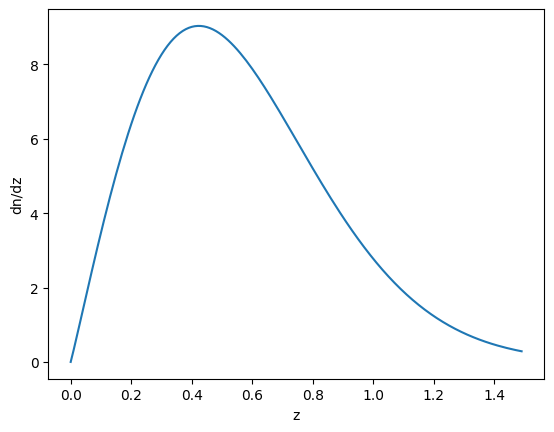

MPI task 0, OMP thread count starts at 0
 MPIThreadsOK = 1

|-------------------------------------------------|
|                      CoLoRe                     |
|-------------------------------------------------|

The cosmological model is:
 O_M=0.300 O_L=0.700 O_K=0.000
 O_B=0.050 w=-1.000 h=0.700
 Flat universe, standard cosmological constant

 Time of equality: a_eq=0.75416
 Particle horizon: chi_H(0)=9.908E+03 Mpc/h
 Present growth factor: D_0=0.779

Reading P_k from file: output/pk.txt
  Original sigma8=0.800014
  Sigma_Gauss should be 0.742601
Node 0 will allocate 4.502 GB [1.509 GB (Gaussian), 2.409 GB (1LPT), 0.496 GB (srcs), 0.088 GB (imap)]

Run parameters: 
  0.001 < z < 1.000
  2.997 < r/(Mpc/h) < 2312.680
  L_box = 4643.428 Mpc/h, N_grid = 512 
  Scales resolved: 1.353E-03 < k < 3.457E-01 h/Mpc
  Fourier-space resolution: dk = 1.353E-03 h/Mpc
  Real-space resolution: dx = 9.069E+00 Mpc/h
  Density field pre-smoothed on scales: x_s = 1.000E+00 Mpc/h
  1 galaxy population

In [ ]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt
import libconf
# from scipy.integrate import simps
from scipy.integrate import simpson
from astropy.io import fits

os.environ["LD_LIBRARY_PATH"] = "/home/roger02/Healpix_3.83/lib:" + os.environ.get("LD_LIBRARY_PATH", "")


n_grid = 512
csm = {'omega_M': 0.3,
       'omega_B': 0.05,
       'omega_L': 0.7,
       'h': 0.7,
       'w': -1.0,
       'ns': 0.96,
       'sigma_8': 0.8}
dirname_out = 'output'
os.system(f'mkdir -p {dirname_out}')

cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')
k_h = np.geomspace(1E-4, 100, 1024)
pk_h = ccl.linear_matter_power(cosmo, k_h*cosmo['h'], 1.)*cosmo['h']**3
np.savetxt(f'{dirname_out}/pk.txt', np.transpose([k_h, pk_h]))




# Redshift distribution

def dndz_des_alonso(zi, amp=22.357, alpha=1.044, z0=0.568, beta=1.742):
    return amp*(zi/z0)**alpha*np.exp(-(zi/z0)**beta)


zs = np.arange(0.0, 1.5, 0.01)
nz = dndz_des_alonso(zs)

bz = np.ones_like(zs)

np.savetxt(f'{dirname_out}/dndz.txt', np.transpose([zs, nz]))
np.savetxt(f'{dirname_out}/bias.txt', np.transpose([zs, bz]))

plt.plot(zs, nz)
plt.ylabel('dn/dz')
plt.xlabel('z')
plt.show()


# Constant background temperature T_HI = 0.05 mK
tz = 0.05 * np.ones_like(zs)

nu_ref = 1420.
nu0 = nu_ref / (1+1.0)
nu1 = nu_ref / (1+0.2)
n_nu = 1
# nu_arr = np.linspace(nu0, nu1, n_nu+1)
nu_arr = np.arange(nu0, nu1, 30) # every 20 MHz

# print(tz, nu_arr)

np.savetxt(f'{dirname_out}/tz.txt', np.transpose([zs, tz]))
np.savetxt(f'{dirname_out}/nuTable.txt', np.transpose([nu_arr[:-1], nu_arr[1:]]))




# ESTOU A FAZER AQUI O nutable.dat
freqs = np.loadtxt(f'{dirname_out}/nuTable.txt')
nutable = np.array([[0.,0.,0.,0.,0.] for i in range(len(freqs))])
if type(freqs[0])==np.float64:
    freqs=[freqs]
for i,k in enumerate(freqs):
    z1, z2 = nu_ref / k[1] - 1, nu_ref / k[0] - 1
    nutable[i] = [i, k[0], k[1], z1, z2]
np.savetxt(f'./nutable.dat', nutable)






# CoLoRe config
config = {}
config['global'] = {'prefix_out': dirname_out + '/colore',
                    'output_format': 'FITS',
                    'output_density': True,
                    'pk_filename': f'{dirname_out}/pk.txt',
                    'z_min': 0.001,
                    'z_max': 1.0,
                    'seed': 1000,
                    'write_pred': False,
                    'just_write_pred': False}
config['field_par'] = {'r_smooth': 1.,
                       'smooth_potential': True,
                       'n_grid': n_grid,
                       'dens_type': 1,
                       'lpt_buffer_fraction': 0.6,
                       'lpt_interp_type': 1,
                       'output_lpt': 0}
config['cosmo_par'] = csm
config['srcs1'] = {'nz_filename': f'{dirname_out}/dndz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'include_lensing': True,
                   'store_skewers': True}
config['imap1'] = {'tbak_filename': f'{dirname_out}/tz.txt',
                   'bias_filename': f'{dirname_out}/bias.txt',
                   'freq_list': f'{dirname_out}/nuTable.txt',
                   'freq_rest': 1420.0,
                   'nside': 256}
with open(f'{dirname_out}/params.cfg', 'w') as configfile:
    libconf.dump(config, configfile)

os.system(f'./../CoLoRe/CoLoRe {dirname_out}/params.cfg > {dirname_out}/log.txt')
f = open(f'{dirname_out}/log.txt', 'r')
print(f.read())
f.close()




In [36]:


# CRIME config
# Galactic synchrotron

galsynch = np.array(['fname_nutable= ./nutable.dat', 'fname_haslam= ../CRIME/data/lambda_haslam408_dsds_ring.fits', 
                     'fname_specin= ../CRIME/data/synchrotron_specind.fits', 'prefix_out= test_gsyn', 'lmin= 10', 'lmax= 1535', 
                     'nside= 256', 'seed= 1001', 'cl_model= galactic_synchrotron', 
                     'amp= 57.0', 'beta= 1.1', 'alpha= 2.07', 'xi= 1.0', 'lref= 1000', 'nu_ref= 130.0', 
                     'do_polarization= 0', 'xi_polarization= 0.5', 'beta_polarization= 3.3', 'fname_faraday= ../CRIME/data/faraday_sigmas.fits'])
np.savetxt('./param_synch.ini', galsynch, fmt='%s', newline='\n')

# Galactic free-free emission

gff = np.array(['fname_nutable= ./nutable.dat', 'fname_haslam= ../CRIME/data/lambda_haslam408_dsds_ring.fits', 
                     'fname_specin= ../CRIME/data/synchrotron_specind.fits', 'prefix_out= test_gff', 'lmin= 10', 'lmax= 1535', 
                     'nside= 256', 'seed= 1001', 'cl_model= galactic_freefree', 
                     'amp= 57.0', 'beta= 1.1', 'alpha= 2.07', 'xi= 1.0', 'lref= 1000', 'nu_ref= 130.0', 
                     'do_polarization= 0', 'xi_polarization= 0.5', 'beta_polarization= 3.3', 'fname_faraday= ../CRIME/data/faraday_sigmas.fits'])
np.savetxt('./param_gff.ini', gff, fmt='%s', newline='\n')

# Extragalactic free-free emission

egff = np.array(['fname_nutable= ./nutable.dat', 'fname_haslam= ../CRIME/data/lambda_haslam408_dsds_ring.fits', 
                     'fname_specin= ../CRIME/data/synchrotron_specind.fits', 'prefix_out= test_egff', 'lmin= 10', 'lmax= 1535', 
                     'nside= 256', 'seed= 1001', 'cl_model= extragalactic_freefree', 
                     'amp= 57.0', 'beta= 1.1', 'alpha= 2.07', 'xi= 1.0', 'lref= 1000', 'nu_ref= 130.0', 
                     'do_polarization= 0', 'xi_polarization= 0.5', 'beta_polarization= 3.3', 'fname_faraday= ../CRIME/data/faraday_sigmas.fits'])
np.savetxt('./param_egff.ini', egff, fmt='%s', newline='\n')

# Point sources

points = np.array(['fname_nutable= ./nutable.dat', 'fname_haslam= ../CRIME/data/lambda_haslam408_dsds_ring.fits', 
                     'fname_specin= ../CRIME/data/synchrotron_specind.fits', 'prefix_out= test_ps', 'lmin= 10', 'lmax= 1535', 
                     'nside= 256', 'seed= 1001', 'cl_model= point_sources', 
                     'amp= 57.0', 'beta= 1.1', 'alpha= 2.07', 'xi= 1.0', 'lref= 1000', 'nu_ref= 130.0', 
                     'do_polarization= 0', 'xi_polarization= 0.5', 'beta_polarization= 3.3', 'fname_faraday= ../CRIME/data/faraday_sigmas.fits'])
np.savetxt('./param_points.ini', points, fmt='%s', newline='\n')



# Execute ForGet for the different foregrounds

os.system(f'./../CRIME/ForGet param_points.ini')   # Point sources
os.system(f'./../CRIME/ForGet param_gff.ini')      # Galactic free-free
os.system(f'./../CRIME/ForGet param_egff.ini')     # Extragalactic free-free'
os.system(f'./../CRIME/ForGet param_synch.ini')    # Galactic synchrotron




|-------------------------------------------------|
|                      ForGet                     |
|-------------------------------------------------|

*** Reading run parameters
  fname_nutable = ./nutable.dat
  fname_haslam = ../CRIME/data/lambda_haslam408_dsds_ring.fits
  fname_specin = ../CRIME/data/synchrotron_specind.fits
  prefix_out = test_ps
  lmin = 10
  lmax = 1535
  nside = 256
  fname_faraday = ../CRIME/data/faraday_sigmas.fits
  cl_model = point_sources
  amp = 5.700E+01
  beta = 1.100E+00
  alpha = 2.070E+00
  xi = 1.000E+00
  lref = 1000
  nu_ref = 1.300E+02
  seed = 1001

*** Generating SCK maps
  Diagonalizing covariance
>    Relative time ellapsed 4.8 ms
  Generating uncorrelated alms
>    Relative time ellapsed 508.9 ms
  Correlating alms
>    Relative time ellapsed 308.3 ms
  Harmonic-transforming
>    Relative time ellapsed 192.3 ms

*** Writing maps test_ps_###.fits
>    Relative time ellapsed 95.4 ms

>    Total time ellapsed 1152.8 ms

|------------------

0

In [4]:

# Galactic free-free emission

gff = np.array(['fname_nutable= ./nutable.dat', 'fname_haslam= ../CRIME/data/lambda_haslam408_dsds_ring.fits', 
                     'fname_specin= ../CRIME/data/synchrotron_specind.fits', 'prefix_out= test_gff', 'lmin= 10', 'lmax= 1535', 
                     'nside= 256', 'seed= 1001', 'cl_model= galactic_freefree', 
                     'amp= 57.0', 'beta= 1.1', 'alpha= 2.07', 'xi= 1.0', 'lref= 1000', 'nu_ref= 130.0', 
                     'do_polarization= 0', 'xi_polarization= 0.5', 'beta_polarization= 3.3', 'fname_faraday= ../CRIME/data/faraday_sigmas.fits'])
np.savetxt('./param_gff.ini', gff, fmt='%s', newline='\n')


os.system(f'./../CRIME/ForGet param_gff.ini')      # Galactic free-free



|-------------------------------------------------|
|                      ForGet                     |
|-------------------------------------------------|

*** Reading run parameters
  fname_nutable = ./nutable.dat
  fname_haslam = ../CRIME/data/lambda_haslam408_dsds_ring.fits
  fname_specin = ../CRIME/data/synchrotron_specind.fits
  prefix_out = test_gff
  lmin = 10
  lmax = 1535
  nside = 256
  fname_faraday = ../CRIME/data/faraday_sigmas.fits
  cl_model = galactic_freefree
  amp = 8.800E-02
  beta = 3.000E+00
  alpha = 2.150E+00
  xi = 3.500E+01
  lref = 1000
  nu_ref = 1.300E+02
  seed = 1001

*** Generating SCK maps
  Diagonalizing covariance
>    Relative time ellapsed 0.1 ms
  Generating uncorrelated alms
>    Relative time ellapsed 244.7 ms
  Correlating alms
>    Relative time ellapsed 35.4 ms
  Harmonic-transforming
>    Relative time ellapsed 63.3 ms

*** Writing maps test_gff_###.fits
>    Relative time ellapsed 20.4 ms

>    Total time ellapsed 367.0 ms

|---------------

0

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   40 / width of table in bytes                        
NAXIS2  =               254451 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   10 / number of fields in each row                   
TTYPE1  = 'TYPE    '           / label for field   1                            
TFORM1  = '1J      '           / data format of field: 4-byte INTEGER           
TUNIT1  = 'NA      '           / physical unit of field                         
TTYPE2  = 'RA      '           / label for field   2                            
TFORM2  = '1E      '        

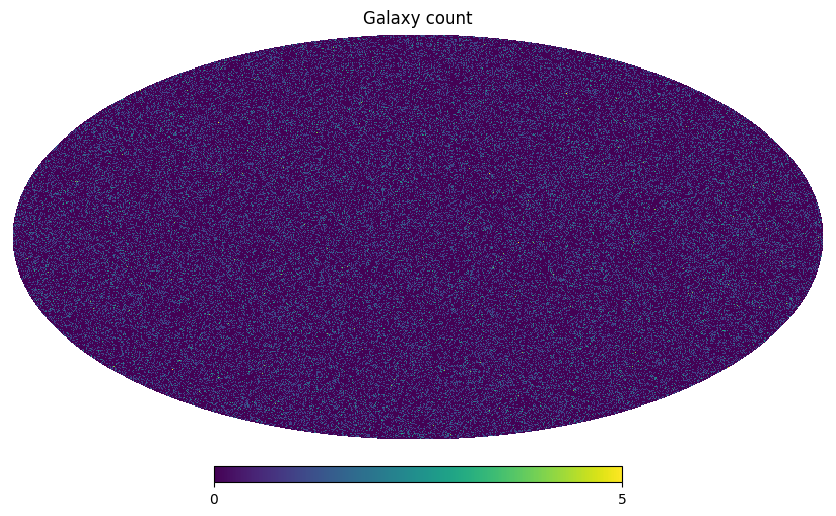

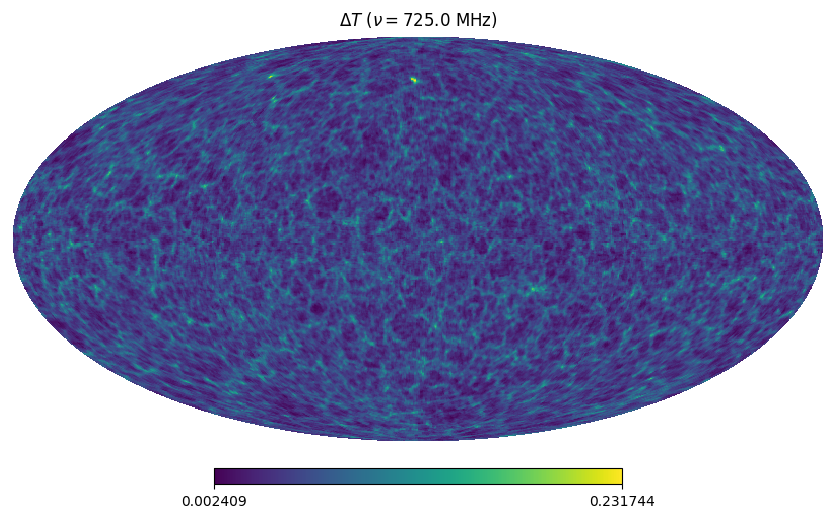

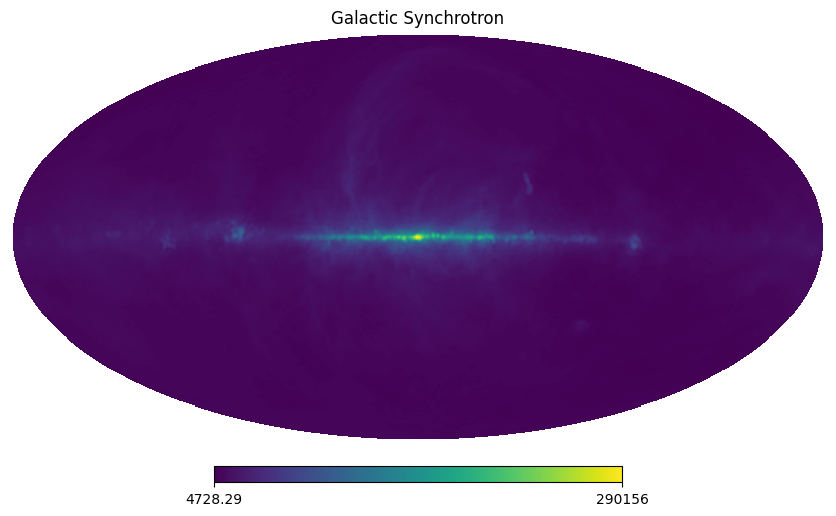

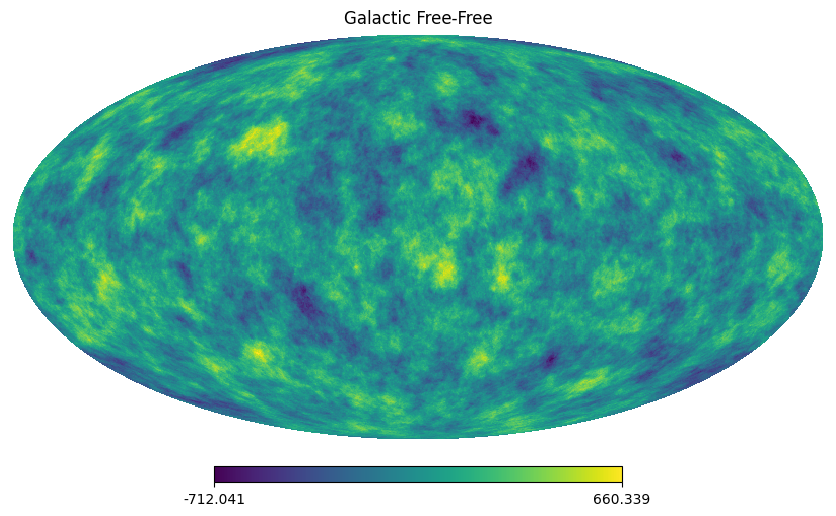

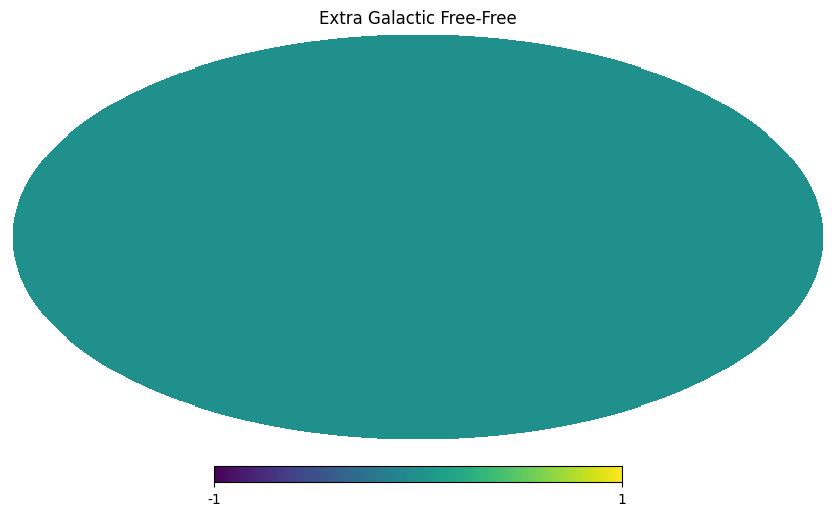

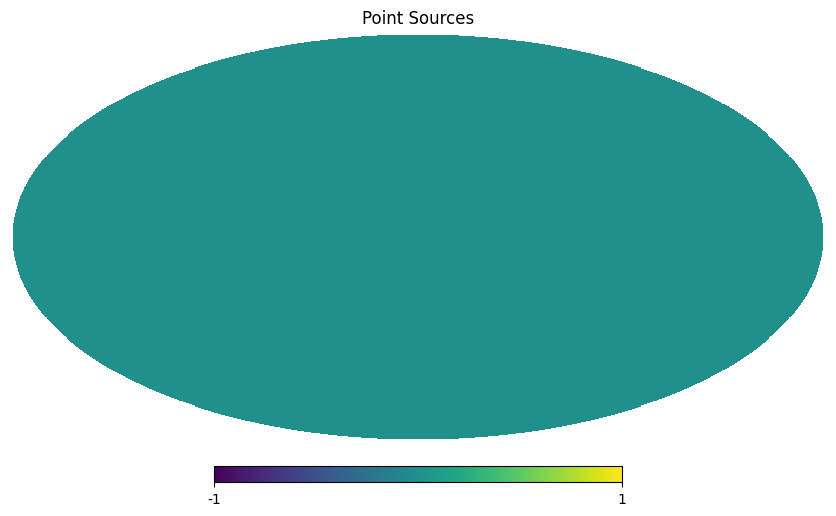

In [126]:
cat = fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1].data
nside = 256
npix = hp.nside2npix(nside)
ipix = hp.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True)
aaa=fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1]
pprint.pp(aaa.header)
ncount = np.bincount(ipix, minlength=npix)
hp.mollview(ncount, title='Galaxy count')
print(sum(ncount))

nu = 0.5*(nu_arr[0] + nu_arr[1])
imap = hp.read_map(f'{dirname_out}/colore_imap_s1_nu000.fits')
hp.mollview(imap, title='$\\Delta T\\,\\,(\\nu = %.1lf\\,\\,{\\rm MHz})$' % nu)
print(imap)

# help(hp.pix2ang)

fg_synch = fits.open("test_gsyn_015.fits")
data_synch = fg_synch[1].data.field(0)
hp.mollview(data_synch, title="Galactic Synchrotron")

fg_gff = fits.open("test_gff_001.fits")
data_gff = fg_gff[1].data.field(0)
hp.mollview(data_gff, title="Galactic Free-Free")

fg_egff = fits.open("test_egff_015.fits")
data_egff = fg_egff[1].data.field(0)
hp.mollview(data_egff, title="Extra Galactic Free-Free")

fg_points = fits.open("test_ps_015.fits")
data_points = fg_points[1].data.field(0)
hp.mollview(data_points, title="Point Sources")


In [38]:
print(len(cat['RA']))


254451


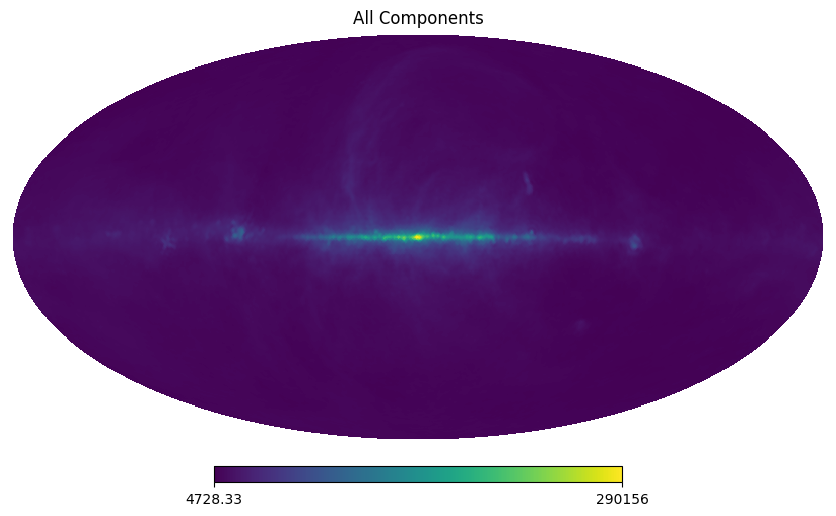

In [39]:
all_comp = imap + data_synch + data_gff + data_egff + data_points
hp.mollview(all_comp, title='All Components')


# TreeCorr

In [89]:
from __future__ import print_function
import treecorr
import fitsio
import time
import pprint
import pandas as pd

file_name = 'output/colore_imap_s1_nu000.fits'
data = fitsio.read(file_name)
print(data.shape)  # 390K objects

imap = hp.read_map(file_name)
nside = hp.get_nside(imap)
npix = hp.get_map_size(imap)

pixel_indices = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixel_indices)
# phi is longitude (0 to 2π), theta is co-latitude (0 to π)
ra = np.degrees(phi)          # Right ascension in degrees
dec = 90.0 - np.degrees(theta) # Declination in degrees (convert from co-latitude)

intensity_values = imap

catalog_imap = treecorr.Catalog(ra=ra, dec=dec, k=intensity_values, 
                          ra_units='deg', dec_units='deg')

print(f"Created catalog with {len(ra)} objects")
print(f"RA range: {ra.min():.2f} to {ra.max():.2f} deg")
print(f"Dec range: {dec.min():.2f} to {dec.max():.2f} deg")

(786432,)
Created catalog with 786432 objects
RA range: 0.00 to 359.82 deg
Dec range: -89.82 to 89.82 deg


bin_size = 0.059915
Time for calculating kk correlation =  7.0531392097473145


<ErrorbarContainer object of 3 artists>

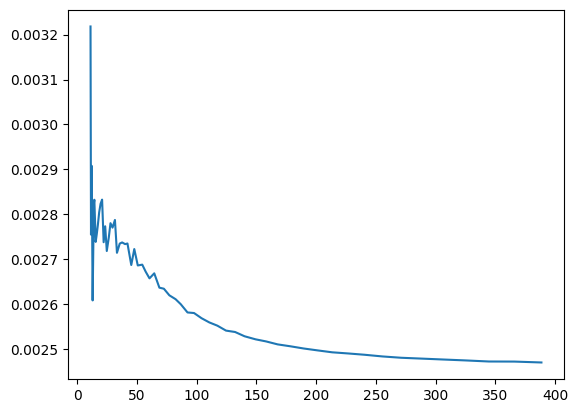

In [90]:
kk = treecorr.KKCorrelation(min_sep=1, max_sep=400, nbins=100, sep_units='arcmin')
print('bin_size = %.6f'%gg.bin_size)

t1 = time.time()
kk.process(catalog_imap)  # Takes approx 1 minute / million objects
t2 = time.time()
print('Time for calculating kk correlation = ',t2-t1)

r = np.exp(kk.meanlogr)
xi = kk.xi
varxi = kk.varxi
plt.errorbar(r[xi>0], xi[xi>0], yerr=varxi[xi>0])#, fmt='.')

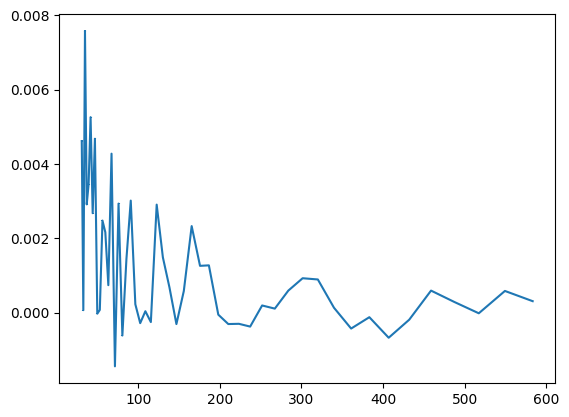

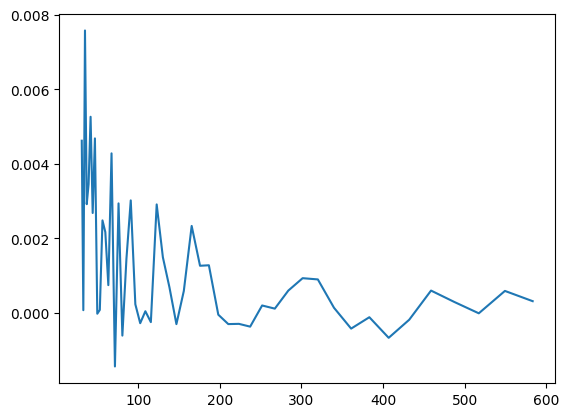

In [ ]:
cat = fits.open(f"{dirname_out}/colore_srcs_s1_0.fits")[1].data
nside = 256
npix = hp.nside2npix(nside)
ipix = hp.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True)
ncount = np.bincount(ipix, minlength=npix)
sources = ncount[ipix]
catalog_sources = treecorr.Catalog(ra=cat["RA"], dec=cat["DEC"], k=sources, 
                          ra_units='deg', dec_units='deg')



DD_L = treecorr.NNCorrelation(min_sep=30, max_sep=600, nbins=50, sep_units='arcmin')
RR_L = treecorr.NNCorrelation(min_sep=30, max_sep=600, nbins=50, sep_units='arcmin')
DR_L = treecorr.NNCorrelation(min_sep=30, max_sep=600, nbins=50, sep_units='arcmin')
RD_L = treecorr.NNCorrelation(min_sep=30, max_sep=600, nbins=50, sep_units='arcmin')
DD_L.process(catalog_sources)

n_pts_rand = int( 5 * len(cat["RA"] ))

def _gen_random_catalogue_theta(RA_min, RA_max, DEC_min, DEC_max, Npoints, seed=None):
    # Code from Pedro Fanha
    # generates a region populated with Npoints random points
    # RA_min, RA_max, DEC_min, DEC_max are floats (limits of square region)
    # Npoints integer (number of points to generate in the random)
    # seed (optional, set it to generate a specific distribution of points)
    
    # https://math.stackexchange.com/questions/711594/uniform-sampling-from-part-of-sphere-surface
    # RA in [0, 360[, DEC in [-90, 90[

    # TO DO: are there any built in functions in scipy stats to do this (inverse CDF?)

    rng = np.random.default_rng(seed)

    # select u, v in region of angles that I want
    phi_min = RA_min/180*np.pi
    phi_max = RA_max/180*np.pi
    
    u_min = phi_min/(2*np.pi)
    u_max = phi_max/(2*np.pi)

    # calculations take phi -> ra (0 to 2pi) ==> u
    # and theta -> dec (0 to pi) ==> v + theta = 0 corresponds to z axis, declination starts at equator
    theta_min_2 = (90 - DEC_min)/180*np.pi
    theta_max_2 = (90 - DEC_max)/180*np.pi
    
    v_min = (np.cos(theta_min_2) + 1)/2
    v_max = (np.cos(theta_max_2) + 1)/2

    u = u_min + (u_max - u_min)*rng.uniform(0, 1, size=Npoints)
    v = v_min + (v_max - v_min)*rng.uniform(0, 1, size=Npoints)

    # transform from u, v to angles phi, theta and then to RA, DEC (convert to degree)
    ra = 2*np.pi*u
    ra_deg = ra/np.pi*180
    dec = np.pi/2 - np.arccos(2*v - 1)
    dec_deg = dec/np.pi*180

    return pd.DataFrame({'RA': ra_deg % 360, 'DEC': dec_deg})

df_sky_pos = _gen_random_catalogue_theta( RA_min=0, RA_max=360, DEC_min=-90, DEC_max=90, Npoints=n_pts_rand, seed=7+15*10 )
Rand = treecorr.Catalog(ra=df_sky_pos["RA"], dec=df_sky_pos["DEC"], ra_units='degrees', dec_units='degrees')
RR_L.process(Rand)
DR_L.process(catalog_sources, Rand)     # z bin 1
RD_L.process(Rand, catalog_sources)     # z bin 2

        # calculating values of clustering estimator, w(theta)
arr_xi_L, varxi_L  = DD_L.calculateXi(rr=RR_L, dr=DR_L, rd=RD_L)
arr_sig_L = np.sqrt(varxi_L)

r = np.exp(DD_L.meanlogr)
xi = arr_xi_L
varxi = varxi_L
plt.errorbar(r[xi>-0.1], xi[xi>-0.1], yerr=varxi[xi>-0.1])#, fmt='.')
plt.show()
plt.plot(r, xi)
# help(plt.errorbar)



# CAMB

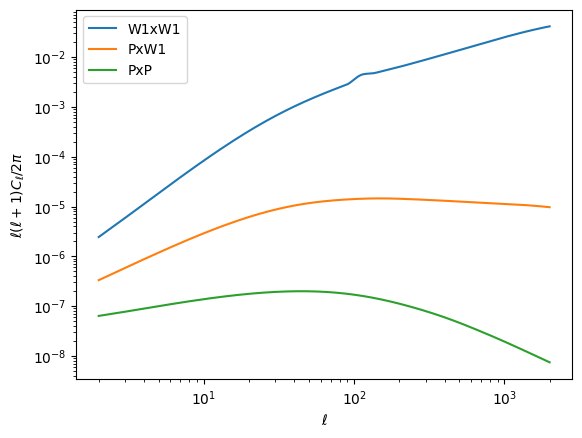

In [12]:
import camb
from camb import model
from camb.sources import SplinedSourceWindow

# Get angular power spectrum for galaxy number counts and lensing
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=0.05, omch2=0.25)
pars.InitPower.set_params(As=2e-9, ns=0.96)
lmax = 2000
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
pars.SourceWindows = [SplinedSourceWindow(z=zs, W=nz, bias_z=bz)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

# Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
# lensing window functions are for kappa (and counts for the fractional angular number density)
ls = np.arange(2, lmax + 1)
for spectrum in ["W1xW1", "PxW1", "PxP"]:
    plt.loglog(ls, cls[spectrum][2 : lmax + 1], label=spectrum)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell/2\pi$")
plt.legend()

# CCL

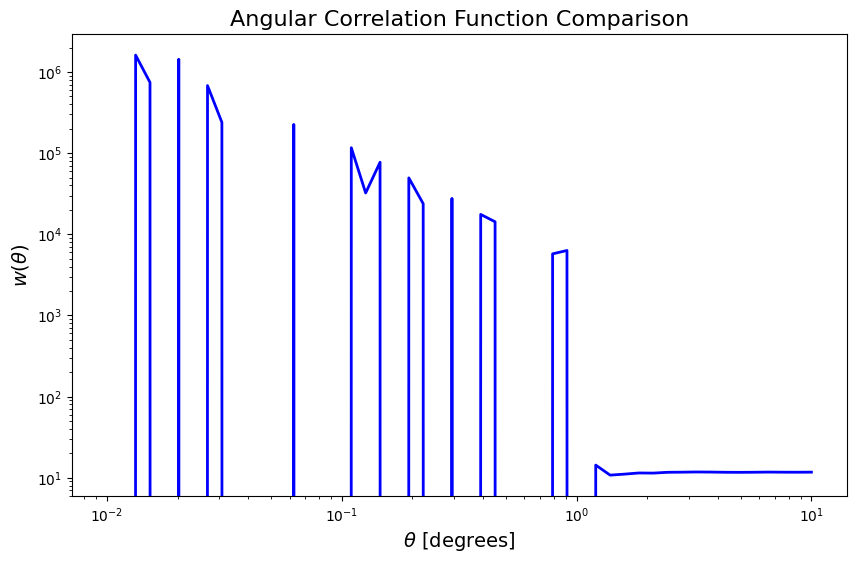

In [ ]:
import pyccl as ccl

ell, C_ell = ls, cls['W1xW1'][2 : lmax + 1]

theta = np.logspace(-2, 1, 50)  # 0.01 to 10 degrees

wtheta = ccl.correlation(cosmo, ell=ell, C_ell=C_ell, 
                         theta=theta, type='NN', method='FFTLog')

plt.figure(figsize=(10, 6))
plt.loglog(theta, wtheta, 'b-', linewidth=2)

plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function Comparison', fontsize=16)
plt.show()